# Plot preliminary track results

In [51]:
import napari
from cellpose import models
from octopuslite import utils, tile
import numpy as np

import sys
sys.path.append('macrohet/')
from notify import send_sms

def view(img):
    return napari.Viewer().add_image(img)

from tqdm.auto import tqdm

import btrack
import dask.array as da

import torch
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
from skimage.transform import rescale, resize, downscale_local_mean


Using device: cuda

NVIDIA RTX A6000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [38]:
image_dir = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/'
metadata_fn = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Index.idx.xml'
metadata = utils.read_harmony_metadata(metadata_fn)

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [39]:
metadata_path = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml'
utils.read_harmony_metadata(metadata_path, assay_layout=True)

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

### Define row and column of choice

In [40]:
row = '5'
column = '4'

### Now to lazily mosaic the images using Dask prior to viewing them.

1x (75,2,3) [TCZ] image stack takes approximately 1 minute to stitch together, so only load the one field of view I want.

In [42]:
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, 
                             column, 
                             #set_channel=1, 
                             set_plane = 'sum_proj',
#                              set_time = 1
                         )#.astype(uint8)

In [43]:
images

,Array,Chunk
Bytes,40.88 GiB,62.02 MiB
Shape,"(75, 2, 6048, 6048)","(1, 2, 2016, 2016)"
Count,16200 Tasks,675 Chunks
Type,uint64,numpy.ndarray


# Downscale images?

In [49]:
gfp = images[:,0,...]
rfp = images[:,1,...]

In [52]:
gfp_images_resized = list()
for t in tqdm(range(len(gfp))):
    gfp_image_resized = rescale(gfp[t], 1200/6048, anti_aliasing=False)
    gfp_images_resized.append(gfp_image_resized)
gfp_images_resized = np.stack(gfp_images_resized, axis = 0)

  0%|          | 0/75 [00:00<?, ?it/s]

In [53]:
rfp_images_resized = list()
for t in tqdm(range(len(rfp))):
    rfp_image_resized = rescale(rfp[t], 1200/6048, anti_aliasing=False)
    rfp_images_resized.append(rfp_image_resized)
rfp_images_resized = np.stack(rfp_images_resized, axis = 0)

  0%|          | 0/75 [00:00<?, ?it/s]

In [54]:
resized_images = np.stack([gfp_images_resized,rfp_images_resized], axis = -1)

# Import tracks

In [3]:
import btrack
import napari

In [94]:
with btrack.dataio.HDF5FileHandler("/mnt/DATA/macrohet/segmentation/[(5, 4)]_tracks.h5", 'r') as hdf:
    tracks = hdf.tracks
data, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim = 2)

[INFO][2023/01/25 05:53:36 pm] Opening HDF file: /mnt/DATA/macrohet/segmentation/[(5, 4)]_tracks.h5...
25-Jan-23 17:53:36 - btrack.dataio - INFO     - Opening HDF file: /mnt/DATA/macrohet/segmentation/[(5, 4)]_tracks.h5...
[INFO][2023/01/25 05:53:36 pm] Loading tracks/obj_type_1
25-Jan-23 17:53:36 - btrack.dataio - INFO     - Loading tracks/obj_type_1
[INFO][2023/01/25 05:53:36 pm] Loading LBEP/obj_type_1
25-Jan-23 17:53:36 - btrack.dataio - INFO     - Loading LBEP/obj_type_1
[INFO][2023/01/25 05:53:36 pm] Loading objects/obj_type_1 (26073, 5) (26073 filtered: None)
25-Jan-23 17:53:36 - btrack.dataio - INFO     - Loading objects/obj_type_1 (26073, 5) (26073 filtered: None)
[INFO][2023/01/25 05:53:37 pm] Closing HDF file: /mnt/DATA/macrohet/segmentation/[(5, 4)]_tracks.h5
25-Jan-23 17:53:37 - btrack.dataio - INFO     - Closing HDF file: /mnt/DATA/macrohet/segmentation/[(5, 4)]_tracks.h5


In [69]:
with btrack.dataio.HDF5FileHandler("/mnt/DATA/macrohet/segmentation/(5,4)_objects_rescaled.h5", 'r') as hdf:
    masks_resized = hdf.segmentation
    objects_resized = hdf.objects

[INFO][2023/01/25 05:36:53 pm] Opening HDF file: /mnt/DATA/macrohet/segmentation/(5,4)_objects_rescaled.h5...
25-Jan-23 17:36:53 - btrack.dataio - INFO     - Opening HDF file: /mnt/DATA/macrohet/segmentation/(5,4)_objects_rescaled.h5...
[INFO][2023/01/25 05:36:53 pm] Loading segmentation (75, 1200, 1200)
25-Jan-23 17:36:53 - btrack.dataio - INFO     - Loading segmentation (75, 1200, 1200)
[INFO][2023/01/25 05:36:53 pm] Loading objects/obj_type_1 (26073, 5) (26073 filtered: None)
25-Jan-23 17:36:53 - btrack.dataio - INFO     - Loading objects/obj_type_1 (26073, 5) (26073 filtered: None)
[INFO][2023/01/25 05:36:54 pm] Closing HDF file: /mnt/DATA/macrohet/segmentation/(5,4)_objects_rescaled.h5
25-Jan-23 17:36:54 - btrack.dataio - INFO     - Closing HDF file: /mnt/DATA/macrohet/segmentation/(5,4)_objects_rescaled.h5


# Upscale tracks?

In [48]:
tracks[0].x = [x*5 for x in tracks[0].x]

AttributeError: can't set attribute

### Tracks are immutable objects so cannot set attribute... instead focus on why it works for smaller images...

In [99]:
v = napari.Viewer()
v.add_image(resized_images, 
            channel_axis = -1, 
            colormap=['green', 'magenta'], 
        #/contrast_limits=[[100,6000],[0,3000]]
           )
# for key in masks_dict.keys():
#     v.add_labels(masks_dict[key][0], name = key)
v.add_labels(
    masks_resized, 
    name = 'masks', 
#     color = {1:'yellow'}, 
    opacity = 0.2
)
v.add_tracks(
                    data, 
                    properties=properties, 
                    graph=graph, 
                    name="Tracks [5,4]", 
                    blending="translucent",
                    visible=False,
                )

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Tracks layer 'Tracks [5,4]' at 0x7f0b41386ca0>

In [5]:
import matplotlib.pyplot as plt

(array([823., 313., 208., 121.,  78.,  82.,  44.,  38.,  19., 112.]),
 array([ 1. ,  8.4, 15.8, 23.2, 30.6, 38. , 45.4, 52.8, 60.2, 67.6, 75. ]),
 <BarContainer object of 10 artists>)

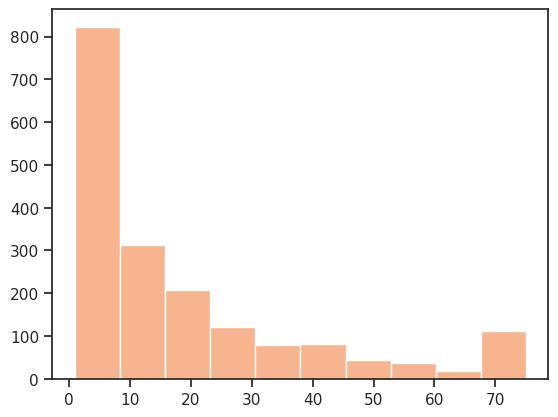

In [56]:
plt.hist([len(track) for track in tracks])

In [29]:
len([len(track) for track in tracks if len(track) >74])

54

In [58]:
long_tracks = [track for track in tracks if len(track) >74]

In [59]:
long_tracks[0]

,ID,t,x,y,z,parent,root,state,generation,dummy,orientation,major_axis_length,mean_intensity-1,mean_intensity-0,minor_axis_length,area
0,275,0,931.136047,11.954831,0.000000,275,275,5,0,False,-1.478021,77.920151,1.985879e-17,6.807045e-17,31.476965,1749.0
1,275,1,931.435181,9.454870,0.000000,275,275,5,0,False,-1.554659,63.020252,1.920431e-17,5.210253e-17,24.531528,1119.0
2,275,2,932.272583,10.708194,0.000000,275,275,5,0,False,-1.491710,59.552567,1.975035e-17,9.238923e-17,27.166481,1196.0
3,275,3,935.061218,12.569156,0.000000,275,275,5,0,False,-0.947255,37.168678,2.003791e-17,1.320364e-16,29.775789,817.0
4,275,4,934.913635,13.580646,0.000000,275,275,5,0,False,-0.933896,41.284641,2.011829e-17,1.066987e-16,31.862869,961.0
5,275,5,939.739319,13.380519,0.000000,275,275,5,0,False,-1.389464,57.996887,1.999016e-17,9.593384e-17,33.271992,1427.0
6,275,6,940.648010,13.859196,0.000000,275,275,5,0,False,-1.288729,56.060192,2.003481e-17,1.170474e-16,35.309647,1392.0
7,275,7,939.308899,14.619484,0.000000,275,275,5,0,False,-1.055386,47.862431,2.050364e-17,1.371336e-16,33.964943,1201.0
8,275,8,941.242004,17.424084,0.000000,275,275,5,0,False,-1.113678,55.400497,2.057314e-17,1.341543e-16,42.346352,1719.0
9,275,9,945.127686,12.827634,0.000000,275,275,5,0,False,-1.386064,60.367085,2.084321e-17,1.479109e-16,32.972950,1433.0


In [152]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")
# sns.set_palette("rocket_r")
sns.set_palette("Spectral")


# Handpicking cells

In [100]:
### previous IDs from previous tracking file
IDs = [2239, 86, 969, 370, ### high int
      275, 287, 211, 245] ### low int

In [158]:
### previous IDs from previous tracking file
IDs = [7, 63, 211, #infected 
       2250, 279, 1797, ### shortlived/merged
      268, 384, 54] ### low int

In [159]:
interest_tracks = [track for track in tracks if track.ID in IDs]

  0%|          | 0/9 [00:00<?, ?it/s]

Text(0, 0.5, 'Intracellular Mtb content \n(Relative fluorescent intensity)')

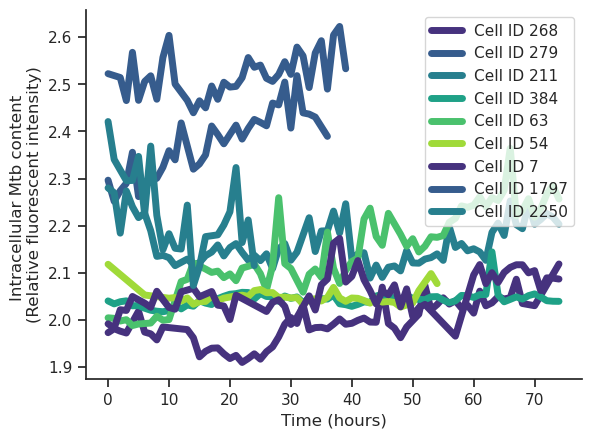

In [160]:
sns.set_palette("viridis")

for n, i in tqdm(enumerate(interest_tracks), total = len(interest_tracks)):
    label = f'Cell ID {i.ID}'
    sns.lineplot(data = i.properties['mean_intensity-1']/1E-17, 
                     label =label, 
                     linewidth = 5
                      )
    sns.despine(offset=0) 
plt.xlabel('Time (hours)')
plt.ylabel('Intracellular Mtb content \n(Relative fluorescent intensity)')

# Highlight cells 

In [141]:
def cell_coords(cell_ID:int):
    track = [track for track in tracks if track.ID == cell_ID][0]
    coords = np.dstack((track.t, track.y, track.x))[0]
    return coords

In [161]:
v = napari.Viewer()
v.add_image(resized_images, 
            channel_axis = -1, 
            colormap=['green', 'magenta'], 
        #/contrast_limits=[[100,6000],[0,3000]]
           )
v.add_points(cell_coords(211), text = '211', size = 10, face_color= 'yellow')
v.add_points(cell_coords(1797), text = '1797', size = 10, face_color = 'red')
v.add_points(cell_coords(63), text = '63', size = 10, face_color = 'red')

v.add_labels(
    masks_resized, 
    name = 'masks', 
#     color = {1:'yellow'}, 
    opacity = 0.2
)
v.add_tracks(
                    data, 
                    properties=properties, 
                    graph=graph, 
                    name="Tracks [5,4]", 
                    blending="translucent",
                    visible=False,
                )

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Tracks layer 'Tracks [5,4]' at 0x7f0b6affee80>

# Make animation with 211 and 1797?

In [162]:
example_tracks =[track for track in tracks if track.ID in [211,1797, 63]]

0it [00:00, ?it/s]

Text(0, 0.5, 'Intracellular Mtb content \n(Relative fluorescent intensity)')

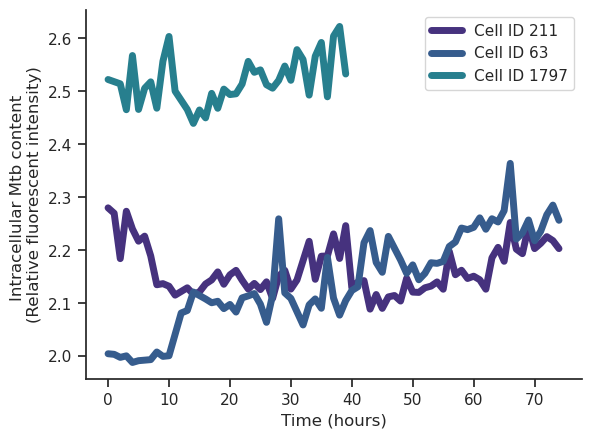

In [166]:
for n, i in tqdm(enumerate(example_tracks)):
    label = f'Cell ID {i.ID}'
    sns.lineplot(data = i.properties['mean_intensity-1']/1E-17, 
                     label =label, 
                     linewidth = 5
                      )
#     x = i.t
#     y = i.properties['mean_intensity-1']/1E-17
#     a,b = np.polyfit(x, y, 3)
#     sns.lineplot(x, a*x+b)
    sns.despine(offset=0) 
plt.xlabel('Time (hours)')
plt.ylabel('Intracellular Mtb content \n(Relative fluorescent intensity)')

# Make polyfit or smoothed line

In [167]:
from scipy.optimize import curve_fit

0it [00:00, ?it/s]

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3397: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


ValueError: All arrays must be of the same length

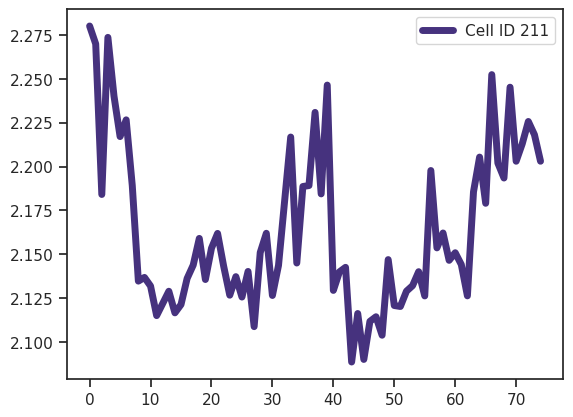

In [189]:
for n, i in tqdm(enumerate(example_tracks)):
    label = f'Cell ID {i.ID}'
    sns.lineplot(data = i.properties['mean_intensity-1']/1E-17, 
                     label =label, 
                     linewidth = 5
                      )
    x = i.t
    y = i.properties['mean_intensity-1']/1E-17
    y = list(pd.Series(y).interpolate())
    p = np.poly1d(np.polyfit(x, list(pd.Series(y).interpolate()), 35))
    x = np.linspace(1, 75, 36)
    sns.lineplot(x=x, y = p)
#     a,b = np.polyfit(x, y, 3)
    break
#     sns.lineplot(x, a*x+b)
    sns.despine(offset=0) 
plt.xlabel('Time (hours)')
plt.ylabel('Intracellular Mtb content \n(Relative fluorescent intensity)')

In [190]:
p

poly1d([ 4.66792998e-56, -1.70722124e-53,  1.96963789e-51, -2.00327565e-50,
       -8.43543958e-48, -5.97216148e-47,  3.88155677e-44,  1.90821794e-42,
       -1.06008237e-40, -1.53366485e-38, -2.73721498e-37,  6.60715171e-35,
        5.08754380e-33, -8.33907644e-32, -3.19190665e-29, -1.07399707e-27,
        1.28989766e-25,  1.08237250e-23, -3.88672635e-22, -6.91209912e-20,
        1.45058389e-18,  3.88736237e-16, -1.58536316e-14, -1.60180245e-12,
        1.98868580e-10, -1.05765242e-08,  3.50461030e-07, -7.92183419e-06,
        1.25573892e-04, -1.39393392e-03,  1.05798930e-02, -5.21933478e-02,
        1.52336265e-01, -2.18619406e-01,  8.28913875e-02,  2.28210867e+00])

In [177]:
np.poly1d(np.polyfit(x, list(pd.Series(y).interpolate()), 2))

poly1d([ 6.55049322e-05, -4.78544270e-03,  2.22049972e+00])

# Smoothing

In [175]:
import pandas as pd

In [175]:
list(pd.Series(y).interpolate())

[1.8238063978338412,
 1.8423547041213306,
 1.9558947199437107,
 1.9979902656557842,
 2.0400858113678577,
 2.059135158518671,
 2.0026590888096947,
 1.9866685577606347,
 1.9162170584960105,
 1.9332179297486083,
 1.9224011062918793,
 1.9286831859956515,
 1.9310088618486023,
 1.9312014530688792,
 1.9391299071725172,
 1.926223490471384,
 1.9521400001465095,
 1.9351059714077221,
 1.9235906701330927,
 1.913669931566415,
 1.9109942066963226,
 1.9162477279734182,
 1.9418001774807818,
 1.9282658015907763,
 1.8955693773972453,
 1.8861938177842865,
 1.8806517845821817,
 1.8793597979245373,
 1.882248709220338,
 1.891039996952278,
 1.907390656404174,
 1.9107558689911304,
 1.9166916117996264,
 1.8881159404562442,
 1.8900657758384352,
 1.889373671892682,
 1.8808417085085438,
 1.9054035575194062,
 1.8981143288228348,
 1.8825927807260852,
 1.8837164873296874,
 1.8801693171757305,
 1.9052384776333728,
 1.9168910754017714,
 1.9207964926917096,
 1.929257111630691,
 1.9162512325407344,
 1.9043637886827662,


  0%|          | 0/8 [00:00<?, ?it/s]

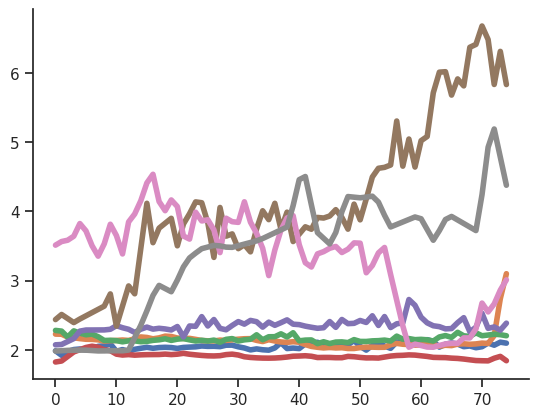

In [185]:
from scipy.interpolate import make_interp_spline, BSpline


for n, i in tqdm(enumerate(interest_tracks), total = len(interest_tracks)):
    x = i.t
    y = i.properties['mean_intensity-1']/1E-17
    y = list(pd.Series(y).interpolate())
    xnew = np.linspace(np.min(x), np.max(x), 75) 
    spl = make_interp_spline(x, y, k=1)
    y_smooth = spl(xnew)
    sns.lineplot(data =y_smooth, 
#                      label =label, 
                     linewidth = 4
                      )
    sns.despine(offset=0) 

In [186]:
from scipy.interpolate import interp1d

  0%|          | 0/8 [00:00<?, ?it/s]

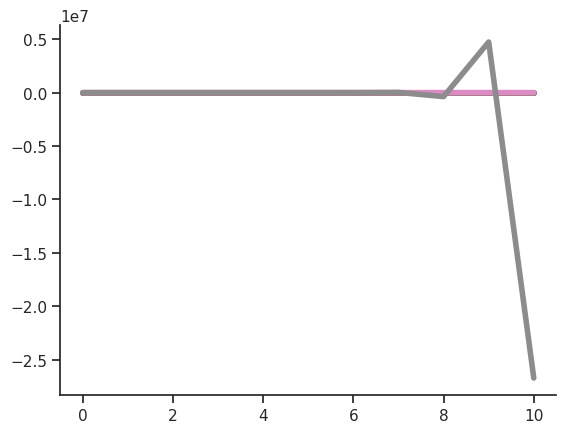

In [192]:
for n, i in tqdm(enumerate(interest_tracks), total = len(interest_tracks)):
    x = i.t
    y = i.properties['mean_intensity-1']/1E-17
    y = list(pd.Series(y).interpolate())
#     x_ = np.linspace(np.min(x), np.max(x), len(x)) 
    p = np.polyfit(x, y, 10)
    sns.lineplot(data =p, 
#                      label =label, 
                     linewidth = 4
                      )
    sns.despine(offset=0) 

# Build pandas df of tracks?

# Previous graph format

In [ ]:
fig, ax = plt.subplots(1,2, sharex = True, sharey = True, 
                      figsize = (9,7))
for n, i in enumerate(plot_rfp_dfs[0].items()):
    label = i[0] + f',(3,{n+4})'
    LHS = sns.lineplot(data = i[1]/1E10,ax=ax[0], label =label, 
                     linewidth = 4
                      )
    sns.despine(ax=ax[0], offset=0) 
    
LHS.set(ylabel = None)
for n, i in enumerate(plot_rfp_dfs[2].items()):
    label = i[0] + f',(5,{n+4})'
    sns.lineplot(data = i[1]/1E10,ax=ax[1], label =label,
                 linewidth = 4
                )
    sns.despine(ax=ax[1], offset=0) # the important part here
plt.ylabel('')
fig.supxlabel('Time (hours)')
fig.supylabel('Mtb-RFP (whole FOV raw intensity)')
plt.suptitle('Mtb growth over the whole field of view (Replication_IPSDM_GFP dataset)')
fig.show()
# plt.savefig('/mnt/DATA/macrohet/results/whole_fov_mtb_growth/single_tile_whole_fov_mtb_growth_row3&5.png', bbox_inches = 'tight', dpi = 314)